# Setup

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'

def latexify(fig_width=None, fig_height=None, columns=3):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2,3])

    # width in inches
    if fig_width is None:
        if columns==1:
            fig_width = 6.9
        elif columns==2:
            fig_width = 3.39 
        else:
            fig_width = 2.2

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pgf',
              'pgf.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              #'font.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [2]:
import matplotlib.pyplot as plt
import os
import argparse
from ast import literal_eval
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import glob
from dateutil import parser

import pandas as pd
import numpy as np

from run import create_model
import config
from src.utils import accumulate_immediate_regret as acc_ir, plot_immediate_regret as plot_ir, immediate_regret as immidiate_regret

df_indexed = None

conf = config.get_config()
df = pd.read_csv(conf['database'])

# Only take the once with 200 iterations
# df = df[df.num_steps == 200]

# Parse arrays
df['ard'] = df.ard.fillna(False)
df['activations'] = df.activations.fillna('[]').apply(literal_eval).apply(tuple)
df['incumbent'] = df.incumbent.fillna('None').apply(literal_eval)
df['immediate_regret'] = df.immediate_regret.fillna('None').apply(literal_eval)
df.date = df.date.astype('datetime64[ns]')

# Remove invalid seeds (set default seed)
# df.loc[df.seed == -1, 'seed'] = 0

# Remove dublicates
df = df.sort_values(by=['date'])
df = df.groupby(["uuid"]).agg(lambda x: x.iloc[0]).reset_index()
df = df.sort_values(by=['date'])

# Make embedding into tuples to support hashing (used in groupby)
df.embedding = df.embedding.fillna('[]')
df.embedding = df.embedding.apply(literal_eval)
df.embedding = [ tuple(row.embedding) for _, row in df.iterrows() ]

def get_model_conf(uid):
    row = df_indexed.loc[uid]
    model_shortname = row['name']
    model_conf = config.get_model_config(uid, model_shortname, conf)
    return model_conf

def plot_ir_image(model_conf):
    display(Image(filename=model_conf['regret_plot_path']))

def plot_step_image(model_conf):
    # l = os.listdir(model_conf['plot_folder'])
    l_all = glob.glob(os.path.join(model_conf['plot_folder'], '*.png'))
    l_all.sort(key=lambda n: int(n.replace(".", "-").split('-')[-2]))
    l_em = [img for img in l_all if "embedding" in img]
    l = [img for img in l_all if "embedding" not in img]

    def show_image(i):
        if i < len(l):
            display(Image(filename=l[i]))
        if i < len(l_em):
            display(Image(filename=l_em[i]))
    
    length = max(len(l), len(l_em))
    # Only if there are images
    if length > 0:
        interact(show_image, i=widgets.IntSlider(min=0, max=length - 1, step=1, value=0))

def get_XY(model_conf):
    X = np.load(model_conf['obs_X_path'])
    Y = np.load(model_conf['obs_Y_path'])
    return X, Y
    
def recreate_model(uid, model_conf, train=True, extra_args=None):
    args_dict = df_indexed.loc[uid].to_dict()
    if extra_args is not None:
        args_dict.update(extra_args)
        
    args = argparse.Namespace(**args_dict)
    args.batch_size = int(args.batch_size) # quick fix
    #args.seed = int(args.seed)             # quick fix
    args.seed = None
        
    bo = create_model(args)
    X,Y = get_XY(model_conf)
    bo.model.init(X, Y, train=train)
    return bo

import itertools
def get_regret_history(uids):
    max_hist = []
    for uid in uids:
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        
        maxy = np.maximum.accumulate(bo.model.Y)

        # Remove output dimension
        maxy = maxy[:,0]
        max_hist.append(maxy)
    # Fills arrays of different length with NaN
    max_hist = np.array(list(itertools.zip_longest(*max_hist, fillvalue=np.nan))).T
    
    mean = np.nanmean(max_hist, axis=0)

    var = np.nanvar(max_hist, axis=0)
    f_opt = bo.f_opt if bo.f_opt is not None else 0
    # top = np.maximum(mean + np.sqrt(var), bo.f_opt)
    # bottom = np.maximum(mean - np.sqrt(var), bo.f_opt)
    #return np.abs(mean + np.sqrt(var) - f_opt), np.abs(mean - f_opt), np.abs(mean - np.sqrt(var) - f_opt), max_hist
    return mean, var, f_opt, max_hist


# Hack to fix row
#df = df.drop(374)
df = df[df.uuid != 'e']

# Give correct type (pytorch does not allow numpy.float64 and numpy.int64)
for col in ['dim_basis', 'dim_h1', 'dim_h2', 'num_nn', 'batch_size', 'epochs', 'num_mcmc', 'n_iter', 'n_init']:
    df[col] = df[col].astype(int)
for col in ['lr', 'weight_decay']:
    df[col] = df[col].astype(float)


df_indexed = df.set_index('uuid')


df.loc[df.group.isin(['funcs', 'funcs1', 'funcs2', 'funcs3', 'funcs4']), 'group'] = 'funcs'
df.loc[df.group.isin(['epoch', 'epoch2']), 'group'] = 'epoch'

df.init_src = df.init_src.fillna('')

# Group the same model and calc regret history
# TODO: add seed
uuid_keys = ['acq', 'batch_size', 'dim_basis', 'dim_h1', 'dim_h2',
         'epochs', 'lr', 'model', 'n_iter', 'nn_aggregator', 'num_mcmc', 'num_nn',
         'weight_decay', 'obj_func', 'embedding', 'activations', 'nn_training', 'n_init', 'group', 'init_src']
gf = df.groupby(uuid_keys)
df_agg = gf.agg(tuple).reset_index()
df_agg['regret_history'] = df_agg.uuid.apply(get_regret_history)
df = df_agg
df['num_runs'] = df.uuid.apply(len)

def select_group(df, GROUP):
    df = df.copy()
        
    print(df.group.unique())
    if type(GROUP) is list:
        df = df[df.group.isin(GROUP)]
    else:
        df = df[df.group == GROUP]
    
    return df

# Load plot afterwards to override..
% matplotlib inline

#import seaborn as sns
import seaborn as sns

sns.set_style("darkgrid")

# Plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
[WARNING] [11:33:37:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:33:37:variance] reconstraining parameters rbf.variance
[WARNING] [11:33:37:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:33:37:variance] reconstraining parameters rbf.variance
[WARNING] [11:33:37:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:33:37:variance] reconstraining parameters rbf.variance
[WARNING] [11:33:37:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:33:37:variance] reconstraining parameters rbf.variance
[WARNING] [11:33:37:lengthscale] 

In [3]:
def show_regret(df_agg, default=None, get_label=lambda row: row['name'][0], rng=None):
    from src.utils import random_hypercube_samples

    def show_ir(obj_func):
        model_rows = df_agg[(df_agg.obj_func == obj_func)]

        # Rand hist
        uid = model_rows.iloc[0].uuid[0]
        model_conf = get_model_conf(uid)
        bo = recreate_model(uid, model_conf, train=False)
        factor = 0.5
        if bo.f_opt is not None:
            n_runs = 10
            n_samples = bo.n_init + bo.n_iter
            rng_ = rng if rng is not None else np.random.RandomState(3)
            rand_hist = bo.obj_func(random_hypercube_samples(n_runs * n_samples, bo.bounds, rng=rng_))
            rng_.shuffle(rand_hist)
            rand_hist = np.reshape(rand_hist, (n_runs, n_samples))
            regret_hist = np.maximum.accumulate(rand_hist, axis=1)
            mean = np.mean(regret_hist, axis=0)
            var = np.var(regret_hist, axis=0)
            regret = immidiate_regret(mean, bo.f_opt)
                
            top = regret + factor *np.sqrt(var)
            bottom = regret - factor * np.sqrt(var)
            plt.plot(regret, label="random")
            plt.fill_between(np.arange(regret.shape[0]), top, bottom, alpha=.2)

            
        for i, row in model_rows.iterrows():
            print("{} {}".format(row.uuid[0], get_label(row)))
            
        for i, row in model_rows.iterrows():
            mean, var, f_opt, originals = row['regret_history']
            #top, mean, bottom, originals = row['regret_history']
            regret = np.abs(mean - f_opt)
            plt.plot(regret, label=get_label(row))
            top = regret + factor * np.sqrt(var)
            bottom = regret - (factor-0.05) * np.sqrt(var)
            plt.fill_between(np.arange(regret.shape[0]), top, bottom, alpha=.2)
            #plt.errorbar(np.arange(mean.shape[0]), mean, np.sqrt(var), label=row['name'][0])
            print("(mean, var, #runs):", mean[-1], var[-1], originals.shape[0])
            #for orig in originals:
            #    plt.plot(orig)
            #break
        # if bo.f_opt is not None:
        plt.yscale('log')
        plt.legend()
    return show_ir


def show_regret_interact(df_agg, default=None, get_label=lambda row: row['name'][0]):
    options = df_agg.obj_func.unique()
    show_func = show_regret(df_agg, get_label=get_label)
    return interact(show_func, obj_func=widgets.Dropdown(
        options=options,
        value=default if default is not None else options[0]))


def show_obj_func(df_agg, plot_predictions=False):
    from src.tests import acc_ir, plot_ir

    def show_prediction(obj_func, embedded):
        if None:
            return
        model_rows = df_agg[(df_agg.obj_func == obj_func)]

        for i, row in model_rows.iterrows():
            uid = row.uuid[0]
            name = row['name'][0]
            print(uid)
            model_conf = get_model_conf(uid)
            bo = recreate_model(uid, model_conf, train=plot_predictions)#, extra_args=dict(num_nn=10, epochs=1000, batch_size=1000))
            print("Model:", name)
            #bo.embedded_dims is not None
            bo.plot_prediction(plot_predictions=plot_predictions, plot_embedded_subspace=embedded)

    return interact(show_prediction, obj_func=list(df_agg.obj_func.unique()), embedded=False)


def get_label(row):
    training_map = {'fixed': 'fixed', 'retrain': 'retrain', 'retrain-reset': 'retrain-reset'}
    model_map = {'gp': 'GP', 'dngo': 'DNGO', 'rand': 'Rand'}
    model = model_map[row.model]
    name = ""
    if row.num_nn > 1:
        name += "{} x ".format(row.num_nn)
    name += model
    if row.model == 'dngo':
        training = training_map[row.nn_training]
        name += ' '
        name += training
    if row.num_mcmc > 0:
        name += ' MCMC'
    return name

# Plots for Paper

## Figure 5 (Branin Acquisition Landscape)

[WARNING] [11:34:57:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:34:57:variance] reconstraining parameters rbf.variance
[WARNING] [11:34:57:variance] reconstraining parameters GP_regression.Gaussian_noise.variance
[WARNING] [11:34:59:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:34:59:variance] reconstraining parameters rbf.variance
[WARNING] [11:34:59:variance] reconstraining parameters GP_regression.Gaussian_noise.variance


... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net


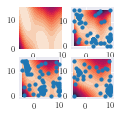

In [7]:

def plot_uid(uid):
    model_conf = get_model_conf(uid)
    bo = recreate_model(uid, model_conf, train=False)
    bo.model.init(bo.model.X, bo.model.Y, train=True)

    bounds = bo.bounds
    dims = bounds.shape[0]
    x0 = np.linspace(bounds[0,0], bounds[0,1], 100)
    x1 = np.linspace(bounds[1,0], bounds[1,1], 100)
    x0v, x1v = np.meshgrid(x0, x1)
    xinput = np.swapaxes(np.array([x0v, x1v]), 0, -1) # set dim axis to last
    xinput = np.swapaxes(xinput, 0, 1)                # swap x0 and x1 axis

    origin_shape = xinput.shape[:-1]
    flattenxinput = xinput.reshape(-1, dims)

    X0 = bo.model.X[:,0]
    X1 = bo.model.X[:,1]

    acq = bo.model.acq(flattenxinput, bo.acquisition_function.calc)
    acq = np.reshape(acq, origin_shape)

    # Plot acq
    plt.contourf(x0v,x1v, acq, 24)
    plt.scatter(X0, X1, s=10)

plt.subplot(2, 2, 1)

uid = '06d4472f'
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=False)
bo.model.init(bo.model.X, bo.model.Y, train=True)

bounds = bo.bounds
dims = bounds.shape[0]
x0 = np.linspace(bounds[0,0], bounds[0,1], 100)
x1 = np.linspace(bounds[1,0], bounds[1,1], 100)
x0v, x1v = np.meshgrid(x0, x1)
xinput = np.swapaxes(np.array([x0v, x1v]), 0, -1) # set dim axis to last
xinput = np.swapaxes(xinput, 0, 1)                # swap x0 and x1 axis

origin_shape = xinput.shape[:-1]
flattenxinput = xinput.reshape(-1, dims)

y = bo.obj_func(flattenxinput)[..., 0]
y = np.reshape(y, origin_shape)
plt.contourf(x0v,x1v, y, 24)
    
# GP
plt.subplot(2, 2, 2)
plot_uid('06d4472f')

# DNGO
plt.subplot(2, 2, 3)
plot_uid('f93d839e')

# Ensemble
plt.subplot(2, 2, 4)
plot_uid('c03bdf5b')

plt.savefig('paper/fig/branin-exploration.pgf')

## Immediate Regret Benchmark Plots

23dbf7ed 5 x DNGO retrain-reset
f11da165 DNGO retrain-reset
e8ff321a GP
(mean, var, #runs): 0.999904893481 9.67661849998e-09 5
(mean, var, #runs): 0.99565683991 4.24124493408e-05 5
(mean, var, #runs): 0.998719813392 4.38252283726e-06 5


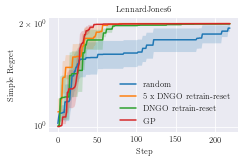

In [37]:
plt.rcParams['pgf.rcfonts'] = True
latexify(columns=2)
df_temp = df[df.group == 'stratified']
show_regret(df_temp, get_label=get_label)('lennardjones6')
plt.title('LennardJones6')
plt.ylabel('Simple Regret')
plt.xlabel('Step')
plt.savefig('paper/fig/lennardjones6.pgf')

b065b58a 5 x DNGO retrain-reset
0f930dbb DNGO retrain-reset
c9b9c71d GP
(mean, var, #runs): -0.0512836085239 0.000504558869752 6
(mean, var, #runs): -0.0262318429596 0.000401329655962 6
(mean, var, #runs): -0.0795961684285 0.00538639276709 6


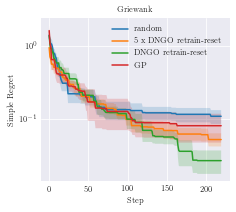

In [12]:
latexify(columns=2, fig_height=3)

df_temp = df[df.group == 'stratified']
show_regret(df_temp, get_label=get_label)('griewank')
plt.title('Griewank')
plt.ylabel('Simple Regret')
plt.xlabel('Step')
plt.savefig('paper/fig/griewank.pgf')


b3f0a718 5 x DNGO retrain-reset
f1cd2f96 DNGO retrain-reset
23d7e0f7 GP
(mean, var, #runs): -4.87892328448 34.4616858807 6
(mean, var, #runs): -8.46422967148 18.9936440443 6
(mean, var, #runs): -6.96697347898 3.09691836451 6


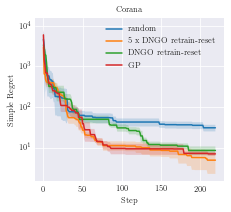

In [13]:
df_temp = df[df.group == 'stratified']
show_regret(df_temp, get_label=get_label)('corana')
plt.title('Corana')
plt.ylabel('Simple Regret')
plt.xlabel('Step')
plt.savefig('paper/fig/corana.pgf')


## GP Hyperparameter Plots

/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

covariance is not positive-semidefinite.



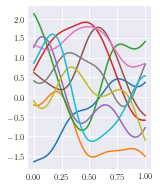

/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

covariance is not positive-semidefinite.



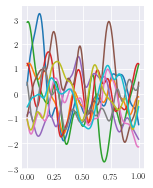

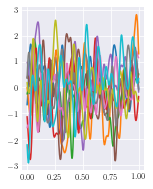

In [17]:
import GPy

latexify(columns=3, fig_height=3)

for l in [0.2, 0.05, 0.02]:
    k = GPy.kern.RBF(input_dim=1,lengthscale=l)
    X = np.linspace(0.,1.,500)
    X = X[:,None]
    mu = np.zeros((500))
    C = k.K(X,X)
    Z = np.random.multivariate_normal(mu,C,10)
    for i in range(Z.shape[0]):
        plt.plot(X[:],Z[i,:])
    #plt.title('Sample ')
    #plt.ylabel('Simple Regret')
    #plt.xlabel('Step')
    plt.savefig('paper/fig/SE-prior-{}.pgf'.format(l))
    plt.show()

## BO 1D Illustrated

/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



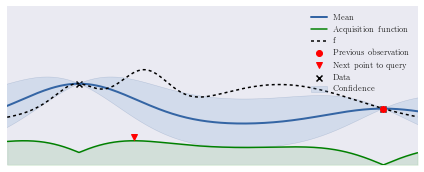

/Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



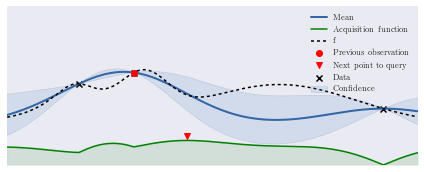

In [18]:
import GPy

latexify(fig_width=6, fig_height=2.5)

def f(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

rng = np.random.RandomState(1)
x_train = np.array([[0.1], [9]])

for i in range(2):
    y_train = f(x_train)

    pmin = -1

    X = np.linspace(-2,10,500)
    X = X[:,None]

    k = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=1.7)
    m = GPy.models.GPRegression(x_train, y_train, noise_var=0.000001, kernel=k)
    mean, var = m.predict(X)
    acq = (mean + 4 * np.sqrt(var))
    acq = acq * 0.5
    acq = acq - np.min(np.abs(acq - pmin))

    m.plot()
    plt.plot(X, acq, color="green", label="Acquisition function")
    plt.fill_between(X[:,0], acq[:,0], np.full(500, -1), color="green", alpha=0.1)

    true_f = f(X)
    plt.plot(X, true_f, dashes=[2, 2], color='black', label="$\mathrm{f}$")
    plt.xlim(-2,10)
    plt.ylim(pmin,3)

    xprev = len(x_train) - 1
    plt.plot([x_train[xprev]], [y_train[xprev]],'ro', markersize=6, label="Previous observation")

    xnext = np.argmax(acq)
    plt.plot([X[xnext]], [acq[xnext]+0.1],'rv', markersize=6, label="Next point to query")
    x_train = np.append(x_train, [X[xnext]], axis=0)
    plt.legend()
    plt.xticks([])
    plt.yticks([])
    plt.savefig('paper/fig/bo-toy-{}.pgf'.format(i))


## A.1. Embedding (SinOne Embedded)

eca5da10 5 x DNGO retrain-reset
45de3edc DNGO retrain-reset
99bd2cb9 GP
(mean, var, #runs): -0.042926462065 4.21926319867e-14 5
(mean, var, #runs): -0.0429267016929 9.87367180722e-14 6
(mean, var, #runs): -0.0429284447852 1.41645440354e-11 10


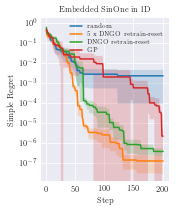

In [19]:
latexify(fig_width=2.3, fig_height=3)
params = {
          'legend.fontsize': 6, # was 10
}

matplotlib.rcParams.update(params)

def get_label(row):
    training_map = {'fixed': 'fixed', 'retrain': 'retrain', 'retrain-reset': 'retrain-reset'}
    model_map = {'gp': 'GP', 'dngo': 'DNGO', 'rand': 'Rand'}
    model = model_map[row.model]
    name = ""
    if row.num_nn > 1:
        name += "{} x ".format(row.num_nn)
    name += model
    if row.model == 'dngo':
        training = training_map[row.nn_training]
        name += ' '
        name += training
    if row.num_mcmc > 0:
        name += ' MCMC'
    return name

df_temp = df[df.group == 'embedding']
df_temp = df_temp[df_temp.embedding == (0,)]
show_regret(df_temp, get_label=get_label, rng=np.random.RandomState(1))('sinone')
plt.title('Embedded SinOne in 1D')
plt.ylabel('Simple Regret')
plt.xlabel('Step')
plt.savefig('paper/fig/sinone-em-1.pgf')


602d7ae8 5 x DNGO retrain-reset
b28070f5 DNGO retrain-reset
9a6ae4b6 GP
(mean, var, #runs): -0.0429269881502 4.96772063874e-13 5
(mean, var, #runs): -0.0429293349049 1.77694262606e-11 6
(mean, var, #runs): -0.0429847352043 1.16529567146e-08 9


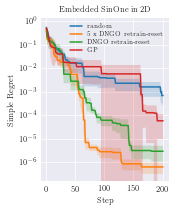

In [20]:
df_temp = df[df.group == 'embedding']
df_temp = df_temp[df_temp.embedding == (0,0)]
show_regret(df_temp, get_label=get_label)('sinone')
plt.title('Embedded SinOne in 2D')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/sinone-em-2.pgf')


5af1f524 5 x DNGO retrain-reset
df6c9958 DNGO retrain-reset
695c9cb9 GP
(mean, var, #runs): -0.0429278673666 4.44266560786e-12 4
(mean, var, #runs): -0.0429582583871 3.10556685724e-09 5
(mean, var, #runs): -0.0632331473264 0.000618542509291 10


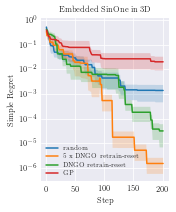

In [21]:
df_temp = df[df.group == 'embedding']
df_temp = df_temp[df_temp.embedding == (0,0,0)]
show_regret(df_temp, get_label=get_label)('sinone')
plt.title('Embedded SinOne in 3D')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/sinone-em-3.pgf')

9e0b5660 5 x DNGO retrain-reset
60306c27 DNGO retrain-reset
099a0ff7 GP
(mean, var, #runs): -0.0600371046538 0.0005659745864 5
(mean, var, #runs): -0.0531338375425 0.000416142807714 5
(mean, var, #runs): -0.0480078832315 0.00023207558315 10


Text(0.5,0,'Step')

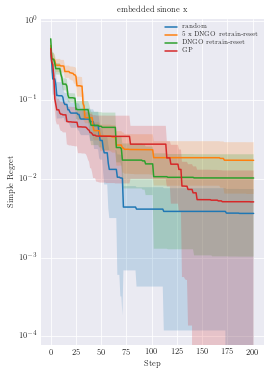

In [22]:
plt.rcParams['figure.figsize'] = (4, 6)

def get_label(row):
    training_map = {'fixed': 'fixed', 'retrain': 'retrain', 'retrain-reset': 'retrain-reset'}
    model_map = {'gp': 'GP', 'dngo': 'DNGO', 'rand': 'Rand'}
    model = model_map[row.model]
    name = ""
    if row.num_nn > 1:
        name += "{} x ".format(row.num_nn)
    name += model
    if row.model == 'dngo':
        training = training_map[row.nn_training]
        name += ' '
        name += training
    if row.num_mcmc > 0:
        name += ' MCMC'
    return name

df_temp = df[df.group == 'embedding']
df_temp = df_temp[df_temp.embedding == (0,0,0,0)]
show_regret(df_temp, get_label=get_label, rng=np.random.RandomState(1))('sinone')
plt.title('embedded sinone x')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

## A.2. Training (Ensemble DNGO Variants)

4d9ca039 DNGO fixed with 20 init samples
86081b3c DNGO fixed with 50 init samples
514675e0 DNGO fixed with 100 init samples
fb705763 DNGO fixed with 200 init samples
(mean, var, #runs): 3.82990596107 0.00152350078841 5
(mean, var, #runs): 3.82965410076 0.00153841671801 6
(mean, var, #runs): 3.82899096062 0.002559061507 6
(mean, var, #runs): 3.85752162628 8.37484297079e-06 6


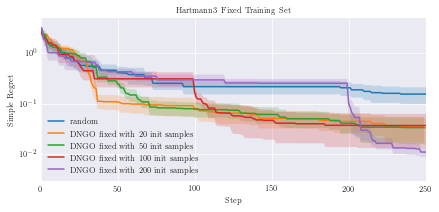

In [23]:
latexify(columns=1, fig_height=3)

def get_label1(row):
    label = get_label(row)
    return label + " with {} init samples".format(row.n_init)

df_temp = df[df.group == 'n_init']
df_temp = df_temp[(df_temp.n_init != 20) | (df_temp.n_iter == 250)]
df_temp = df_temp.sort_values('n_init')
show_regret(df_temp, get_label=get_label1)('hartmann3')
plt.xlim(0, 250)
plt.title('Hartmann3 Fixed Training Set')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/hartmann3-n-init.pgf')

1659fcee DNGO fixed
9c45ede2 DNGO retrain
f93d839e DNGO retrain-reset
06d4472f GP
(mean, var, #runs): -0.420170090636 0.000373363381718 6
(mean, var, #runs): -0.402514434744 9.49479542896e-06 6
(mean, var, #runs): -0.402247936338 1.30374140089e-05 6
(mean, var, #runs): -0.39788940448 1.42094157848e-11 6


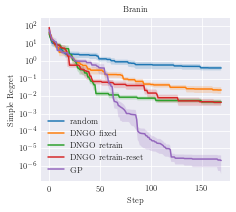

In [24]:
latexify(columns=2, fig_height=3)

df_temp = df[df.group == 'funcs']
df_temp = df_temp[(df_temp.num_mcmc == 0) & (df_temp.num_nn == 1)]
show_regret(df_temp, get_label=get_label)('branin')
plt.title('Branin')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/branin-nn-training.pgf')

64ddeb18 DNGO fixed
0980fcf3 DNGO retrain
eaa92612 DNGO retrain-reset
aaa23973 GP
(mean, var, #runs): 3.85430066683 3.12876662636e-05 6
(mean, var, #runs): 3.84540174329 0.00128966262688 6
(mean, var, #runs): 3.86250719145 2.09816960022e-08 6
(mean, var, #runs): 3.86277347182 5.32685201508e-11 6


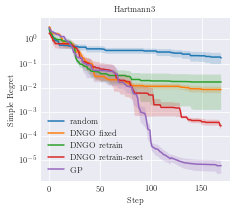

In [25]:
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[(df_temp.num_mcmc == 0) & (df_temp.num_nn == 1)]
#df_temp = df_temp[(df_temp.nn_training != 'retrain')]
show_regret(df_temp, get_label=get_label1)('hartmann3')
plt.title('Hartmann3')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/hartmann3-nn-training.pgf')

## A.3. Benchmarks

c542ec78 5 x DNGO retrain-reset
2701fb82 DNGO retrain-reset
08fc2a65 GP
(mean, var, #runs): -0.00128646986038 4.26326586716e-07 6
(mean, var, #runs): -0.00161773472605 7.6777224962e-07 6
(mean, var, #runs): -0.00509606227932 8.34955689707e-06 5


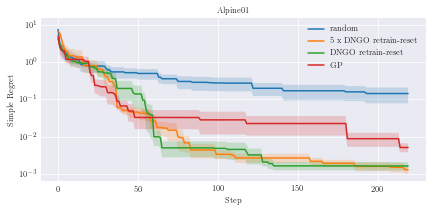

In [14]:
latexify(columns=1, fig_height=3)
df_temp = df[df.group == 'stratified']
show_regret(df_temp, get_label=get_label)('alpine01')
plt.title('Alpine01')
plt.ylabel('Simple Regret')
plt.xlabel('Step')
plt.savefig('paper/fig/alpine01.pgf')


82ca8213 5 x DNGO retrain-reset
92ee64dd DNGO retrain-reset
04e45dbe GP
(mean, var, #runs): -512.931508496 64320.8018181 8
(mean, var, #runs): -493.642041742 47937.5251354 8
(mean, var, #runs): -628.647136441 82684.4175142 8


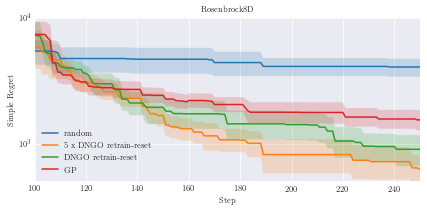

In [33]:
latexify(columns=1, fig_height=3)

def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'highdim']
df_temp = df_temp[df_temp.init_src == '']
df_temp = df_temp[(df_temp.num_mcmc == 0)]
plt.xlim(100, 250)
plt.ylim(500, 10000)
show_regret(df_temp, get_label=get_label1)('rosenbrock8D')
plt.title('Rosenbrock8D')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/rosenbrock8D.pgf')

### Griekwank Acquisition Landscape

[WARNING] [11:33:46:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:33:46:variance] reconstraining parameters rbf.variance
[WARNING] [11:33:46:variance] reconstraining parameters GP_regression.Gaussian_noise.variance
[WARNING] [11:33:51:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [11:33:51:variance] reconstraining parameters rbf.variance
[WARNING] [11:33:51:variance] reconstraining parameters GP_regression.Gaussian_noise.variance


... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net


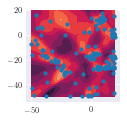

In [6]:
latexify(fig_width=3.39/2, fig_height=3.39/2)

def plot_uid(uid):
    model_conf = get_model_conf(uid)
    bo = recreate_model(uid, model_conf, train=True)
    bo.model.init(bo.model.X, bo.model.Y, train=True)

    bounds = bo.bounds
    dims = bounds.shape[0]
    x0 = np.linspace(bounds[0,0], bounds[0,1], 100)
    x1 = np.linspace(bounds[1,0], bounds[1,1], 100)
    x0v, x1v = np.meshgrid(x0, x1)
    xinput = np.swapaxes(np.array([x0v, x1v]), 0, -1) # set dim axis to last
    xinput = np.swapaxes(xinput, 0, 1)                # swap x0 and x1 axis

    origin_shape = xinput.shape[:-1]
    flattenxinput = xinput.reshape(-1, dims)

    X0 = bo.model.X[:,0]
    X1 = bo.model.X[:,1]

    acq = bo.model.acq(flattenxinput, bo.acquisition_function.calc)
    acq = np.reshape(acq, origin_shape)

    # Plot acq
    plt.contourf(x0v,x1v, acq, 10)
    plt.scatter(X0, X1, s=10)

# plt.subplot(2, 2, 1)

uid = 'c9b9c71d'
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=False)
bo.model.init(bo.model.X, bo.model.Y, train=True)

bounds = bo.bounds
dims = bounds.shape[0]
x0 = np.linspace(bounds[0,0], bounds[0,1], 100)
x1 = np.linspace(bounds[1,0], bounds[1,1], 100)
x0v, x1v = np.meshgrid(x0, x1)
xinput = np.swapaxes(np.array([x0v, x1v]), 0, -1) # set dim axis to last
xinput = np.swapaxes(xinput, 0, 1)                # swap x0 and x1 axis

origin_shape = xinput.shape[:-1]
flattenxinput = xinput.reshape(-1, dims)

y = bo.obj_func(flattenxinput)[..., 0]
y = np.reshape(y, origin_shape)
plt.contourf(x0v,x1v, y, 10)

plt.savefig('paper/fig/griewank-exploration-1.pgf')
plt.close()
# GP
#plt.subplot(2, 2, 2)
plot_uid('c9b9c71d')
plt.savefig('paper/fig/griewank-exploration-2.pgf')
plt.close()
# DNGO
#plt.subplot(2, 2, 3)
plot_uid('0f930dbb')
plt.savefig('paper/fig/griewank-exploration-3.pgf')
plt.close()

# Ensemble
#plt.subplot(2, 2, 4)
plot_uid('b065b58a')
plt.savefig('paper/fig/griewank-exploration-4.pgf')
    
#plt.savefig('paper/fig/griewank-exploration.pgf')

## A.4. Machine Learning Hyperparameter Optimization Tasks

c68aa97f 5 x DNGO fixed
f0061a69 DNGO fixed
59aa7e28 DNGO retrain-reset
43577cbe DNGO retrain-reset MCMC
3ba6b85a GP
6c9d4a28 GP MCMC
4652fbad Rand
(mean, var, #runs): -0.0689243168112 4.68117472733e-07 3
(mean, var, #runs): -0.0718365924113 6.12426049571e-06 3
(mean, var, #runs): -0.0690516213337 7.34755313694e-08 3
(mean, var, #runs): -0.0694848831195 8.69431609179e-07 3
(mean, var, #runs): -0.0678089527119 4.34300910663e-07 3
(mean, var, #runs): -0.0674540907964 2.37421881001e-08 2
(mean, var, #runs): -0.0976534200291 5.94025833014e-05 3


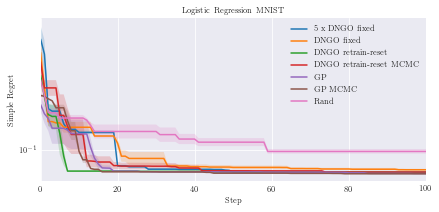

In [31]:
latexify(columns=1, fig_height=3)

def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
show_regret(df_temp, get_label=get_label1)('lr_mnist')
plt.title('Logistic Regression MNIST')
plt.ylabel('Simple Regret')
plt.xlabel('Step')
plt.xlim(0,100)
plt.savefig('paper/fig/lr_mnist.pgf')

e1434888 DNGO retrain-reset
fac11578 GP
999daa81 Rand
(mean, var, #runs): -0.89710643372 1.03975230477e-09 3
(mean, var, #runs): -0.896966526844 0.0 1
(mean, var, #runs): -0.897074078582 1.15673764801e-08 2


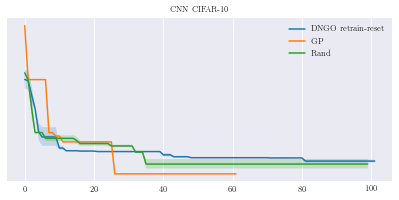

In [32]:
def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[df_temp.init_src == '']
show_regret(df_temp, get_label=get_label1)('cnn_cifar10')
plt.title('CNN CIFAR-10')
plt.savefig('paper/fig/cnn-cifar10.png')

## A.5. Miscellaneous

915c0eb0 5 x DNGO retrain-reset
612c049f DNGO retrain-reset
2ae8e71a GP
51ab30f8 GP MCMC
(mean, var, #runs): 3.26823068657 0.00390208130918 6
(mean, var, #runs): 3.24852474866 0.00426843348014 6
(mean, var, #runs): 3.24758605048 0.00837567167461 6
(mean, var, #runs): 3.25853257706 0.00643337458267 5


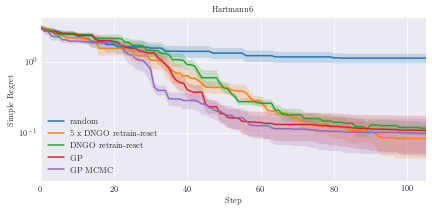

In [29]:
latexify(columns=1, fig_height=3)

def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[~((df_temp.model == 'dngo') & (df_temp.num_mcmc > 0))]
df_temp = df_temp[((df_temp.model != 'dngo') | (df_temp.nn_training == 'retrain-reset'))]
df_temp = df_temp[(df_temp.nn_training != 'retrain')]
show_regret(df_temp, get_label=get_label1)('hartmann6')
plt.xlim(0,105)
plt.title('Hartmann6')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/hartmann6-gp-vs-dngo.pgf')

4ec2a72c DNGO retrain-reset with 100 epochs
12d2b2c7 DNGO retrain-reset with 1000 epochs
32548bba DNGO retrain-reset with 10000 epochs
(mean, var, #runs): 3.86206199684 3.10642115533e-07 6
(mean, var, #runs): 3.86242536338 3.13795486812e-08 6
(mean, var, #runs): 3.86247954028 1.93982868231e-08 6


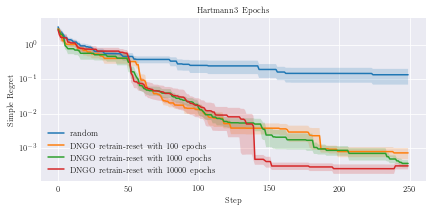

In [27]:
latexify(columns=1, fig_height=3)

def get_label1(row):
    label = get_label(row)
    return label + " with {} epochs".format(row.epochs)

df_temp = df[df.group == 'epoch']
df_temp = df_temp[df_temp.nn_training == 'retrain-reset']
show_regret(df_temp, get_label=get_label1)('hartmann3')
plt.title('Hartmann3 Epochs')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/hartmann3-epoch.pgf')

## Unused

a92c6066 5 x DNGO retrain
915c0eb0 5 x DNGO retrain-reset
7819112e DNGO retrain
612c049f DNGO retrain-reset
(mean, var, #runs): 3.23669013705 0.00348331032582 6
(mean, var, #runs): 3.26823068657 0.00390208130918 6
(mean, var, #runs): 3.19360102864 0.0014032147437 6
(mean, var, #runs): 3.24852474866 0.00426843348014 6


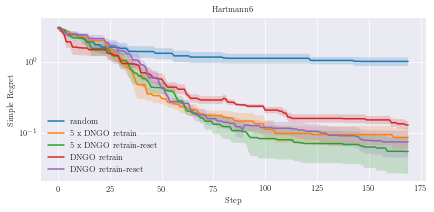

In [26]:
latexify(columns=1, fig_height=3)

def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[((df_temp.model == 'dngo') & (df_temp.nn_training != 'fixed'))]
show_regret(df_temp, get_label=get_label1)('hartmann6')
plt.title('Hartmann6')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper.fig/pgf')

5045c862 10 x DNGO fixed
a8659690 5 x DNGO fixed MCMC
dcca4821 DNGO fixed
(mean, var, #runs): 3.07859062092 0.0 6
(mean, var, #runs): 3.10995334613 0.0145735301984 5
(mean, var, #runs): 2.91781667169 0.177369185789 6


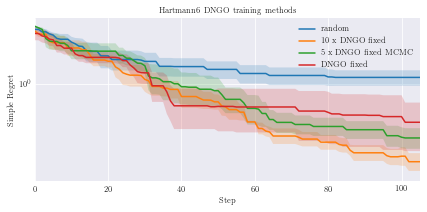

In [30]:
latexify(columns=1, fig_height=3)

def get_label1(row):
    label = get_label(row)
    return label

df_temp = df[df.group == 'funcs']
df_temp = df_temp[((df_temp.model == 'dngo') & (df_temp.nn_training == 'fixed'))]
show_regret(df_temp, get_label=get_label1)('hartmann6')
plt.xlim(0, 105)
plt.title('Hartmann6 DNGO training methods')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/hartmann6-nn-ensemble-size.pgf')

cf86e6f3 DNGO retrain-reset with batch size 10
b065869f DNGO retrain-reset with batch size 20
1caca5f0 DNGO retrain-reset with batch size 40
71004f94 DNGO retrain-reset with batch size 80
1b00d86a DNGO retrain-reset with batch size 160
a48b1e1f DNGO retrain-reset with batch size 320
(mean, var, #runs): 3.86141165454 1.21128725729e-06 6
(mean, var, #runs): 3.73337810305 0.0830568003269 6
(mean, var, #runs): 3.86223397053 9.61128939864e-08 6
(mean, var, #runs): 3.86243388797 1.3733575819e-08 6
(mean, var, #runs): 3.86244218227 3.22446651332e-08 6
(mean, var, #runs): 3.86255055841 2.40643844117e-08 6


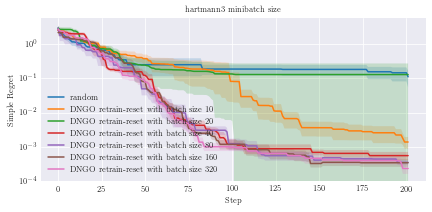

In [28]:
def get_label1(row):
    label = get_label(row)
    return label + ' with batch size {}'.format(row.batch_size)

df_temp = df[df.group == 'minibatch']
#df_temp = df_temp[df_temp.batch_size != 20]
show_regret(df_temp, get_label=get_label1)('hartmann3')
plt.title('hartmann3 minibatch size')
plt.ylabel('Simple Regret')
plt.xlabel('Step')

plt.savefig('paper/fig/hartmann3-minibatch.pgf')

# Exploring

## Create and run model

[WARNING] [13:38:28:lengthscale] reconstraining parameters rbf.lengthscale
[WARNING] [13:38:28:variance] reconstraining parameters rbf.variance
[WARNING] [13:38:28:variance] reconstraining parameters GP_regression.Gaussian_noise.variance


... starting round 0 / 200


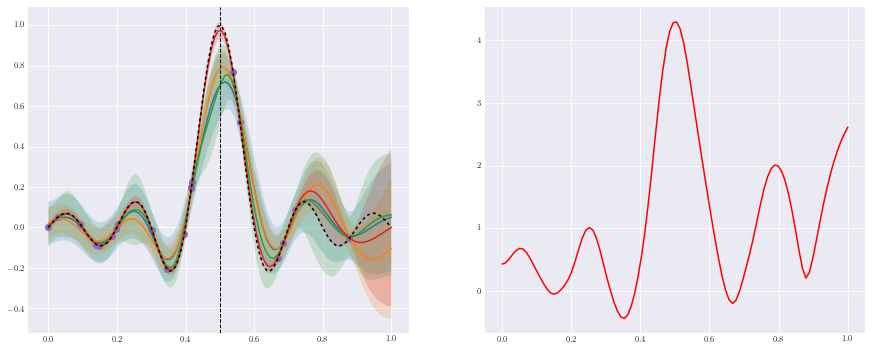

... starting round 1 / 200


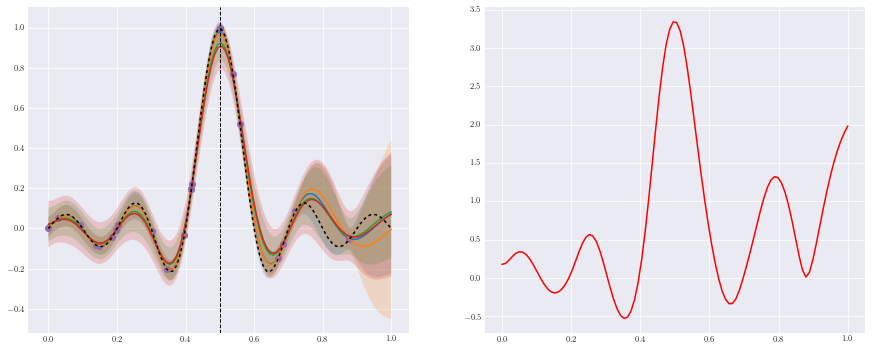

... starting round 2 / 200


KeyboardInterrupt: 

In [50]:
% matplotlib inline

import argparse
from run import create_model
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (15, 6)
sns.set_style("darkgrid")

def f(x):
   return np.sinc(x * 10 - 5).sum(axis=-1)[:, None]

args_dict = {
             'model': 'gp', # options: 'dngo', 'gp'
             # nn
             'activations': ('relu', 'relu', 'tanh'),
             'weight_decay': 0.0001,
             'batch_size': 1000,
             'dim_basis': 50,
             'dim_h1': 50,
             'dim_h2': 50,
             'epochs': 1000,
             'lr': 0.01,
             # GP
             'num_mcmc': 4, # has to be even due to MCMC method.
             'ard': False,
             # Ensemble
             'nn_aggregator': 'average',
             'nn_training': 'fixed',
             'num_nn': 1,
             # BO
             'acq': 'UCB',
             'seed': 1,
             'n_init': 20,
             'n_iter': 200,
    
             # Objective function (either as function or function name)
             'obj_func': (f, np.array([[0,1]]), 0), # options: 'branin', ...
             'embedding': (),}
args = argparse.Namespace(**args_dict)
bo = create_model(args)
bo.run(do_plot=True)

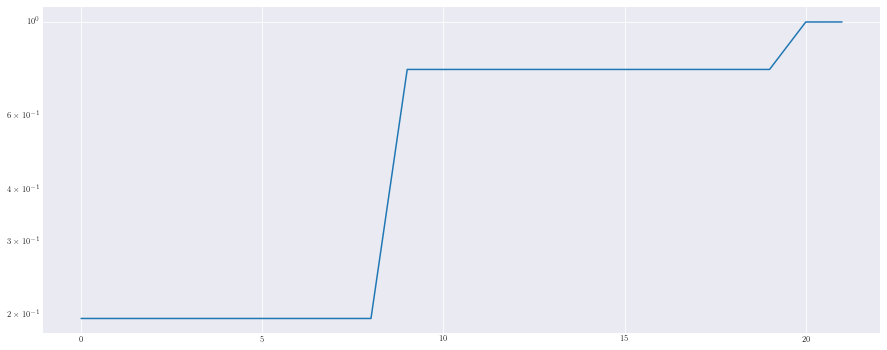

In [51]:
plot_ir([acc_ir(bo.model.Y, bo.f_opt)])

## Recreate model

This section has interact plot selection. It can plot the aquisition landscape and regret plot for a given benchmark function. The regret plot will contain a confidence interval based on all runs with the same model configuration.

In [62]:
df[:3]

,acq,batch_size,dim_basis,dim_h1,dim_h2,epochs,lr,model,n_iter,nn_aggregator,...,uuid,date,immediate_regret,incumbent,name,num_steps,seed,ard,regret_history,num_runs
0,UCB,10,50,50,50,1000,0.01,dngo,200,median,...,"(cf86e6f3, 85bd2489, fc591d22, eace7ce0, d5d03...","(2018-08-27 09:20:00.006013, 2018-08-27 09:24:...","([0.00127375], [0.00038613], [0.00134671], [0....","([3.86150578], [3.8623934], [3.86143283], [3.8...",(cf86e6f3--g-minibatch-m-dngo-bs-10-nnt-retrai...,"(200.0, 200.0, 200.0, 200.0, 200.0, 200.0)","(nan, nan, nan, nan, nan, nan)","(False, False, False, False, False, False)","([1.16817422393, 1.36629102985, 1.36629102985,...",6
1,UCB,20,50,50,50,1000,0.01,dngo,200,median,...,"(b065869f, faa62b8b, 8d8d65bf, 7550626b, 3024c...","(2018-08-27 09:23:01.844471, 2018-08-27 09:24:...","([0.00058063], [0.0002918], [0.00021795], [0.7...","([3.8621989], [3.86248773], [3.86256158], [3.0...",(b065869f--g-minibatch-m-dngo-bs-20-nnt-retrai...,"(200.0, 200.0, 200.0, 200.0, 200.0, 200.0)","(nan, nan, nan, nan, nan, nan)","(False, False, False, False, False, False)","([0.903122284089, 1.13193698125, 1.145532813, ...",6
2,UCB,40,50,50,50,1000,0.01,dngo,200,median,...,"(1caca5f0, 03214643, fc2f4d89, 9965b1d6, 43905...","(2018-08-27 09:23:03.310541, 2018-08-27 09:24:...","([0.00056095], [0.00116783], [0.00022899], [0....","([3.86221858], [3.8616117], [3.86255054], [3.8...",(1caca5f0--g-minibatch-m-dngo-bs-40-nnt-retrai...,"(200.0, 200.0, 200.0, 200.0, 200.0, 200.0)","(nan, nan, nan, nan, nan, nan)","(False, False, False, False, False, False)","([1.30034372431, 1.6595859578, 1.6595859578, 1...",6


In [87]:
# OBS: Modify following filter.
df_temp = df[(df.group == 'stratified') & (df.obj_func == 'griewank')]
#df_temp = df[(df.obj_func == 'branin')]
df_temp = df[(df.obj_func == 'sinone') & (df.embedding == (0,))]

In [88]:
df_temp

,acq,batch_size,dim_basis,dim_h1,dim_h2,epochs,lr,model,n_iter,nn_aggregator,...,uuid,date,immediate_regret,incumbent,name,num_steps,seed,ard,regret_history,num_runs
40,UCB,1000,50,50,50,1000,0.01,dngo,200,average,...,"(eca5da10, 58bb3a83, 9cd9b411, 76e2344b, d082e...","(2018-08-28 07:38:33.437995, 2018-08-28 07:38:...","([4.15155493e-09], [8.7763431e-09], [5.2981772...","([-0.04292635], [-0.04292635], [-0.04292687], ...",(eca5da10--g-em-m-dngo-nnt-retrain-reset-nn-5-...,"(200.0, 200.0, 200.0, 200.0, 200.0)","(nan, nan, nan, nan, nan)","(False, False, False, False, False)","([-0.447003257252, -0.274610421016, -0.2719958...",5
56,UCB,1000,50,50,50,1000,0.01,dngo,200,median,...,"(45de3edc, 6882600c, 3bb69e16, d879d302, de78a...","(2018-08-27 10:35:57.570362, 2018-08-27 10:35:...","([5.92328124e-08], [8.91741974e-07], [6.152381...","([-0.0429264], [-0.04292723], [-0.04292696], [...",(45de3edc--g-em-m-dngo-nnt-retrain-reset-init-...,"(200.0, 200.0, 200.0, 200.0, 200.0, 200.0)","(nan, nan, nan, nan, nan, nan)","(False, False, False, False, False, False)","([-0.614196176508, -0.337900258517, -0.3168736...",6
100,UCB,1000,50,50,50,1000,0.01,gp,200,median,...,"(99bd2cb9, f414bb02, 556d8dcc, f84bc6a4, 030ae...","(2018-08-27 14:43:17.409367, 2018-08-27 14:43:...","([9.89208715e-14], [4.08893959e-06], [4.879651...","([-0.04292634], [-0.04293043], [-0.04293122], ...",(99bd2cb9--g-em-m-gp-init-2-k-200-em-0-f-sinon...,"(200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(False, False, False, False, False, True, True...","([-0.4950316616, -0.449812991533, -0.367016137...",10


In [83]:
def plot(uid):
    model_conf = get_model_conf(uid)
    try:
        plot_step_image(model_conf)
        plot_ir_image(model_conf)
    except Exception as e:
        print(e)
    return uid, model_conf

widget = interactive(plot, uid=list(zip(df_temp.name, df_temp.uuid.apply(lambda uuids: uuids[0]))))
display(widget)

interactive(children=(Dropdown(description='uid', options=((('602d7ae8--g-em-m-dngo-nnt-retrain-reset-nn-5-agg…

In [74]:
df_temp = df[df.group == 'stratified']
show_regret_interact(df_temp, get_label=get_label)

interactive(children=(Dropdown(description='obj_func', options=('alpine01', 'corana', 'cube', 'dolan', 'gear',…

<function __main__.show_regret.<locals>.show_ir(obj_func)>

### Plot 2D Acqusition Surface (interactive)

In [ ]:
uid = 'cf86e6f3' # gp '9c994b1d'
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=False)
bo.model.init(bo.model.X[:20], bo.model.Y[:20], train=True)
fig = bo.plot_2D_surface(use_plotly=True)
iplot(fig)

### Ensemble Aggregator Comparison in SinOne Embedding


... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net
... fitting neural net


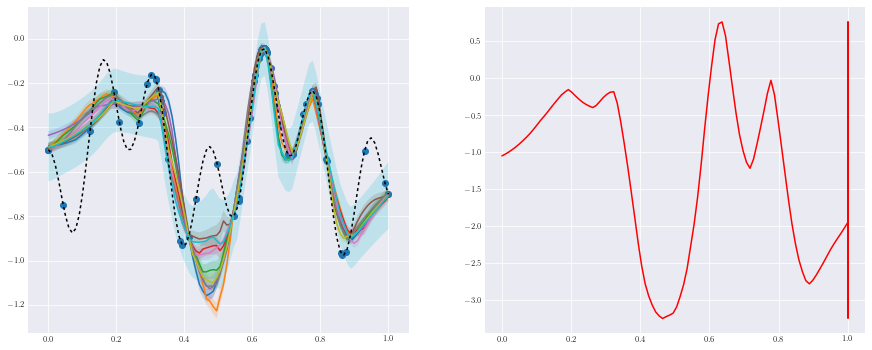

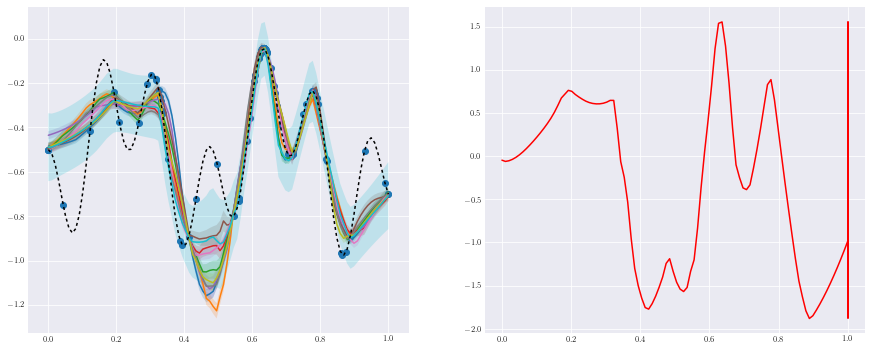

In [91]:
uid = "eca5da10"
model_conf = get_model_conf(uid)
bo = recreate_model(uid, model_conf, train=True, extra_args=dict(num_nn=10, epochs=1000, batch_size=1000, lr=0.001))
bo.model.ensemble_aggregator = np.mean
bo.plot_prediction(plot_predictions=True, plot_embedded_subspace=True)
bo.model.ensemble_aggregator = np.max
bo.plot_prediction(plot_predictions=True, plot_embedded_subspace=True)